
#  Carlos Álvarez

### **Git-hub: https://github.com/Alvarez527**
### **Linkedin: www.linkedin.com/in/cralvarez-ai**

# PyTorch

- Objective

    The primary aim of this activity is to transition from using Numpy for network implementation to utilizing PyTorch, a powerful deep learning framework. You will be replicating the work you did for the ASL dataset in Activity 1b, but this time, you'll implement a your multi layer FC model using PyTorch.
    
- Instructions

    Review Previous Work: Begin by reviewing your Numpy-based Fully Connected Network for the ASL dataset from Activity 1b. Note the architecture, hyperparameters, and performance metrics for comparison.

    Introduce PyTorch: If you're new to PyTorch, take some time to familiarize yourself with its basic operations and syntax. You can consult the official documentation or follow online tutorials.

    Prepare the ASL Dataset: As before, download and preprocess the Kaggle ASL dataset. 

    Implement the Network: Design your network architecture tailored for the ASL dataset. Pay special attention to PyTorch modules like nn.Linear() and nn.ReLU().

    Train the Model: Implement the training loop, making use of PyTorch's autograd to handle backpropagation. Monitor metrics like loss and accuracy as the model trains.

    Analyze and Document: In Markdown cells, discuss the architecture choices, any differences in performance between the Numpy and PyTorch implementations, and insights gained from using a deep learning framework like PyTorch.

## Importar librerías

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Importar imágenes 

In [6]:
from get_images import get_images

In [8]:
# MNIST path
mnist_path = './archive'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float64)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float64)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float64)
y_test = y_test_num.copy().reshape(10000, 1)

## Normalizar imágenes

In [10]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [12]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [14]:
x_train.mean(), x_train.std()

(-9.646705203355238e-18, 0.9999999999999997)

## Mostrar imágenes 

In [16]:
x_test.shape

(10000, 784)

In [18]:
y_train.shape

(50000, 1)

In [20]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 0


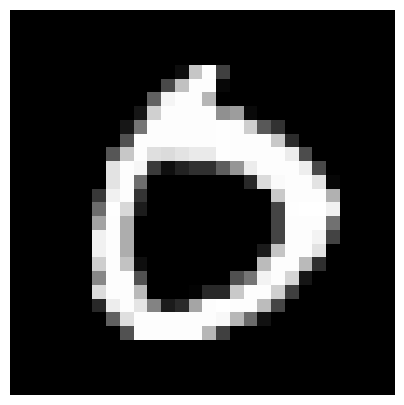

In [22]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

## Crear minibatches 

In [24]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Ahora sí! PyTorch

## Convertir Numpy array a PyTorch 

In [26]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


## Usar GPU de estar disponible

In [28]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cpu


## Compute accuracy 

In [30]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval() #Particularidad de pytorch para evaluar el modelo, no se requiere calcular gradientes
    model = model.to(device=device) #se indica donde se quiere correr el modelo
    with torch.no_grad(): #se pide no calcular gradientes
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32) #se cargan los modelos a la memoria de gpu o cpu
            yi = yi.to(device=device, dtype = torch.long) #se cargan los modelos a la memoria de gpu o cpu
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size ), de el indice del numero mayor a lo largo de las columnas
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     
            

## Loop de entrenamiento

In [32]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train() #Se pide que el modelo se encuentre en modo entrenamiento
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad() #se ponen los gradientes en cero de la iteración anterior
            cost.backward() #se calculan los gradientes
            optimiser.step() #se actualizan los valores W y b
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')
    

## Modelo usando Sequential

In [34]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
lr = 5e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size, epochs)

Epoch: 0, costo: 1.9158837795257568, accuracy: 0.71826171875
Epoch: 1, costo: 1.287726879119873, accuracy: 0.798828125
Epoch: 2, costo: 0.8749881386756897, accuracy: 0.855224609375
Epoch: 3, costo: 0.6630003452301025, accuracy: 0.8681640625
Epoch: 4, costo: 0.566522479057312, accuracy: 0.8837890625
Epoch: 5, costo: 0.5219600796699524, accuracy: 0.88427734375
Epoch: 6, costo: 0.4339170753955841, accuracy: 0.89794921875
Epoch: 7, costo: 0.42387667298316956, accuracy: 0.8955078125
Epoch: 8, costo: 0.4075073003768921, accuracy: 0.903564453125
Epoch: 9, costo: 0.38412296772003174, accuracy: 0.90576171875
Epoch: 10, costo: 0.3311651349067688, accuracy: 0.904296875
Epoch: 11, costo: 0.334409236907959, accuracy: 0.9111328125
Epoch: 12, costo: 0.3114036023616791, accuracy: 0.910888671875
Epoch: 13, costo: 0.3718222379684448, accuracy: 0.91357421875
Epoch: 14, costo: 0.300380140542984, accuracy: 0.914306640625
Epoch: 15, costo: 0.31382298469543457, accuracy: 0.91259765625
Epoch: 16, costo: 0.261

In [35]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.96435546875